# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022


## 1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

### 1.1 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### 1.2 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from typing import Dict, List, Tuple

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_validation_loop, test_loop, BasicCNNClassifier, TestNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/learning_pipeline'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_learning_pipeline.yml')

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)    

PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0


### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )


validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list


### 2.3 Plotting Class Distribution


{'BKGR': 36, '4CV': 36}
{'BKGR': 8, '4CV': 8}


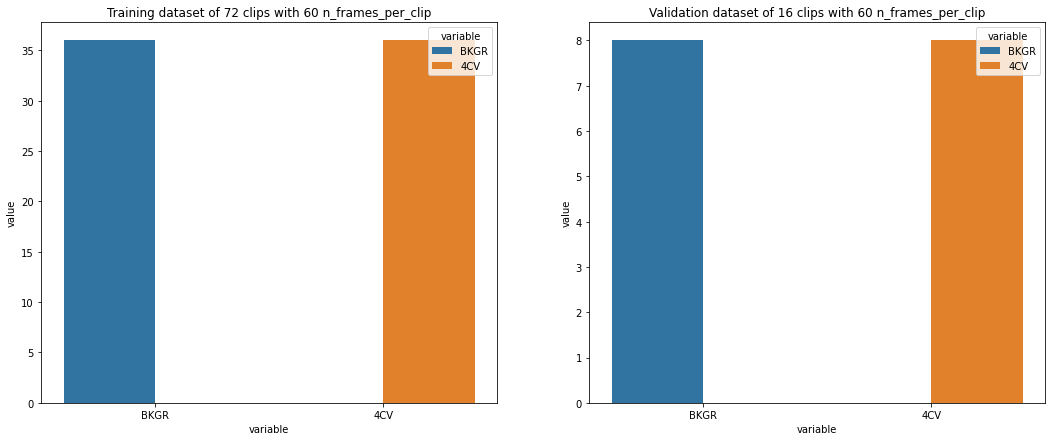

In [3]:
label_id = ('BKGR', '4CV')

number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 


def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)



print(get_class_distribution(train_dataset))

print(get_class_distribution(validation_dataset))


plot_title_train_label= f'Training dataset of {len(train_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'Validation dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution(train_dataset), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[1])
plt.show()






### 2.4 Animating frames of one clip of the dataloader

Clip Size of data_clip_idx torch.Size([60, 1, 128, 128]) of BKGR label


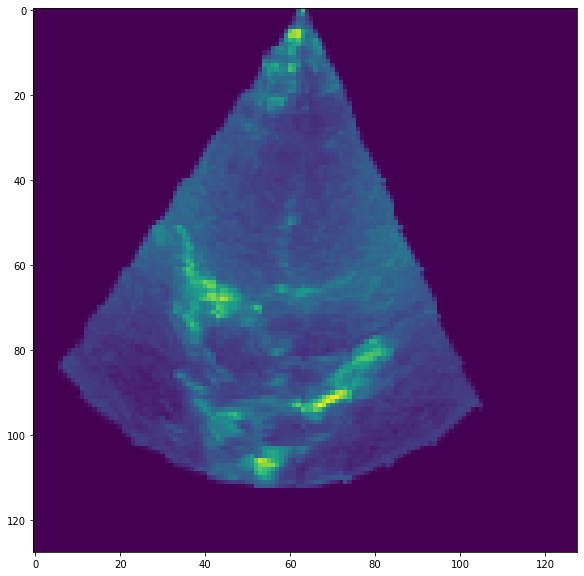

In [4]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 21
data_clip_idx = train_dataset[clip_idx][0]
data_clip_label = train_dataset[clip_idx][1]
print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)

HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### 2.5 Displayting frames in the dataloader

In [5]:
BATCH_SIZE_OF_CLIPS = 10

print(f' train_dataset.__len__() = {train_dataset.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)


print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)





# print(f' train_dataloader.__len__() = {train_dataloader.__len__()}' )

# for clip_batch_idx, sample_batched in enumerate(train_dataloader):
#     print(f'----------------------------------------------------------')
#     sample_batched_images=sample_batched[0]
#     sample_batched_labels=sample_batched[1]
#     print(f'   BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
#     print(f'   SAMPLE_IDX_LABELS: {  sample_batched_labels  }')
#     print(f'   SAMPLE_BATCH: {sample_batched_images.size()}')
    
#     sample_batched=sample_batched_images #.squeeze()
#     print(f'   SAMPLE_BATCH.squeeze: {sample_batched.size()}')
    
#     for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
#         print(BATCH_SIZE_IDX, label)
#         sample_batched_idx_image = sample_batched[BATCH_SIZE_IDX,...]
#         print(f'   sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )
        
#         grid = utils.make_grid(sample_batched_idx_image)
#         print(f'   Grid size {grid.size()}' )
# #         plt.figure(figsize =(20,20) )
# #         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
# #         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
# #         plt.axis('off')
# #         plt.ioff()
# #         plt.show()



 train_dataset.__len__() = 72
 validation_dataset.__len__() = 16


### 2.6 Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.


In [6]:
LEARNING_RATE = 0.000001
MAX_EPOCHS = 100 #config['max_epochs']

model = BasicCNNClassifier(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device)
## PRINT MODEL
print(f'----------------------------------------------------------')
print(model)


### PRINT model.named_parameters
print(f'----------------------------------------------------------')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
    
        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()


----------------------------------------------------------
BasicCNNClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=983040, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
----------------------------------------------------------
classifier.1.weight tensor([[ 7.3400e-04, -3.6872e-04, -6.6105e-04,  ..., -2.9440e-04,
         -5.4753e-04,  8.4166e-04],
        [-9.2924e-04, -4.5071e-04,  5.2524e-04,  ..., -2.4956e-04,
         -6.1563e-04, -1.7673e-04],
        [ 3.4649e-04,  3.7108e-04,  8.3652e-04,  ..., -7.6243e-04,
         -5.9095e-05,  2.5003e-04],
        ...,
        [-4.4325e-04,  9.9263e-04, -4.1170e-04,  ...,  1.0733e-04,
         -4.4557e-04, -2.8788e-04],
        [-8.9026e-04,  7.7781e-04,  4.7998e-04,  ..., -7.5618e-04,
         -7.8493e-04, -7.5617e-04],
        [ 1.0082e-03, -3.0270e-04,  9.1278e-04,  ..., -6.1248e-04,
         -3.8

### 2.7 Training loop

In [7]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.

loss_stats = {
    'train': [],
    "val": []
}
accuracy_stats = {
    'train': [],
    "val": []
}

for epoch in tqdm(range(1, MAX_EPOCHS)):   
#for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc = train_validation_loop(train_dataloader, val_dataloader, model, criterion, optimizer, device)

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
        
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['val'].append(val_epoch_loss)

    accuracy_stats['train'].append(train_epoch_acc)
    accuracy_stats['val'].append(val_epoch_acc)
            

print(loss_stats)
print(accuracy_stats)
    #epoch_loss /= step

    #test_loop(test_dataloader, model_net, loss_function, device)


  0%|                                                                                                                                                                  | 0/99 [00:00<?, ?it/s]

----------
EPOCH 2/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  1%|█▌                                                                                                                                                        | 1/99 [00:02<03:38,  2.23s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 01: | Average Train Loss: 0.699 | Average Train Acc: 46.25000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.68750 
----------
EPOCH 3/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  2%|███                                                                                                                                                       | 2/99 [00:03<03:09,  1.95s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 02: | Average Train Loss: 0.704 | Average Train Acc: 45.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.06250 
----------
EPOCH 4/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  3%|████▋                                                                                                                                                     | 3/99 [00:05<02:58,  1.86s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 03: | Average Train Loss: 0.696 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 5/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  4%|██████▏                                                                                                                                                   | 4/99 [00:07<02:52,  1.81s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 04: | Average Train Loss: 0.680 | Average Train Acc: 58.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.68750 
----------
EPOCH 6/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  5%|███████▊                                                                                                                                                  | 5/99 [00:09<02:48,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 05: | Average Train Loss: 0.685 | Average Train Acc: 55.00000 | Average Validation Loss: 0.087 | Average Validation Acc: 5.81250 
----------
EPOCH 7/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  6%|█████████▎                                                                                                                                                | 6/99 [00:11<02:46,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 06: | Average Train Loss: 0.669 | Average Train Acc: 57.50000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.68750 
----------
EPOCH 8/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  7%|██████████▉                                                                                                                                               | 7/99 [00:12<02:44,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 07: | Average Train Loss: 0.705 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 9/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  8%|████████████▍                                                                                                                                             | 8/99 [00:14<02:41,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 08: | Average Train Loss: 0.711 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 10/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


  9%|██████████████                                                                                                                                            | 9/99 [00:16<02:38,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 09: | Average Train Loss: 0.686 | Average Train Acc: 58.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 11/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 10%|███████████████▍                                                                                                                                         | 10/99 [00:18<02:36,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 10: | Average Train Loss: 0.675 | Average Train Acc: 53.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 12/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 11%|█████████████████                                                                                                                                        | 11/99 [00:19<02:34,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 11: | Average Train Loss: 0.692 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 13/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 12%|██████████████████▌                                                                                                                                      | 12/99 [00:21<02:33,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 12: | Average Train Loss: 0.689 | Average Train Acc: 55.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 14/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 13%|████████████████████                                                                                                                                     | 13/99 [00:23<02:32,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 13: | Average Train Loss: 0.691 | Average Train Acc: 45.00000 | Average Validation Loss: 0.087 | Average Validation Acc: 5.81250 
----------
EPOCH 15/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 14%|█████████████████████▋                                                                                                                                   | 14/99 [00:25<02:31,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 14: | Average Train Loss: 0.677 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.25000 
----------
EPOCH 16/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 15%|███████████████████████▏                                                                                                                                 | 15/99 [00:26<02:30,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 15: | Average Train Loss: 0.692 | Average Train Acc: 48.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.93750 
----------
EPOCH 17/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 16%|████████████████████████▋                                                                                                                                | 16/99 [00:28<02:28,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 16: | Average Train Loss: 0.690 | Average Train Acc: 65.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 8.93750 
----------
EPOCH 18/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 17%|██████████████████████████▎                                                                                                                              | 17/99 [00:30<02:27,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 17: | Average Train Loss: 0.684 | Average Train Acc: 61.25000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.68750 
----------
EPOCH 19/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 18%|███████████████████████████▊                                                                                                                             | 18/99 [00:32<02:25,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 18: | Average Train Loss: 0.691 | Average Train Acc: 50.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.68750 
----------
EPOCH 20/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 19%|█████████████████████████████▎                                                                                                                           | 19/99 [00:34<02:23,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 19: | Average Train Loss: 0.694 | Average Train Acc: 60.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 9.56250 
----------
EPOCH 21/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 20%|██████████████████████████████▉                                                                                                                          | 20/99 [00:35<02:20,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 20: | Average Train Loss: 0.686 | Average Train Acc: 53.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 8.56250 
----------
EPOCH 22/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 21%|████████████████████████████████▍                                                                                                                        | 21/99 [00:37<02:17,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 21: | Average Train Loss: 0.677 | Average Train Acc: 65.00000 | Average Validation Loss: 0.087 | Average Validation Acc: 6.43750 
----------
EPOCH 23/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 22%|██████████████████████████████████                                                                                                                       | 22/99 [00:39<02:15,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 22: | Average Train Loss: 0.678 | Average Train Acc: 58.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.87500 
----------
EPOCH 24/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 23%|███████████████████████████████████▌                                                                                                                     | 23/99 [00:41<02:13,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 23: | Average Train Loss: 0.692 | Average Train Acc: 53.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 6.68750 
----------
EPOCH 25/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 24%|█████████████████████████████████████                                                                                                                    | 24/99 [00:42<02:10,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 24: | Average Train Loss: 0.690 | Average Train Acc: 58.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 7.68750 
----------
EPOCH 26/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 25%|██████████████████████████████████████▋                                                                                                                  | 25/99 [00:44<02:09,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 25: | Average Train Loss: 0.670 | Average Train Acc: 68.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 7.93750 
----------
EPOCH 27/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 26%|████████████████████████████████████████▏                                                                                                                | 26/99 [00:46<02:07,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 26: | Average Train Loss: 0.672 | Average Train Acc: 68.75000 | Average Validation Loss: 0.086 | Average Validation Acc: 9.18750 
----------
EPOCH 28/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 27%|█████████████████████████████████████████▋                                                                                                               | 27/99 [00:48<02:05,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 27: | Average Train Loss: 0.679 | Average Train Acc: 67.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.56250 
----------
EPOCH 29/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 28%|███████████████████████████████████████████▎                                                                                                             | 28/99 [00:49<02:03,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 28: | Average Train Loss: 0.687 | Average Train Acc: 61.25000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.56250 
----------
EPOCH 30/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 29%|████████████████████████████████████████████▊                                                                                                            | 29/99 [00:51<02:02,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 29: | Average Train Loss: 0.673 | Average Train Acc: 75.00000 | Average Validation Loss: 0.085 | Average Validation Acc: 5.81250 
----------
EPOCH 31/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 30%|██████████████████████████████████████████████▎                                                                                                          | 30/99 [00:53<02:00,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 30: | Average Train Loss: 0.684 | Average Train Acc: 53.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 6.68750 
----------
EPOCH 32/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 31%|███████████████████████████████████████████████▉                                                                                                         | 31/99 [00:55<01:58,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 31: | Average Train Loss: 0.678 | Average Train Acc: 65.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 7.68750 
----------
EPOCH 33/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 32%|█████████████████████████████████████████████████▍                                                                                                       | 32/99 [00:56<01:56,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 32: | Average Train Loss: 0.678 | Average Train Acc: 66.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.75000 
----------
EPOCH 34/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 33%|███████████████████████████████████████████████████                                                                                                      | 33/99 [00:58<01:54,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 33: | Average Train Loss: 0.645 | Average Train Acc: 72.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 6.25000 
----------
EPOCH 35/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 34%|████████████████████████████████████████████████████▌                                                                                                    | 34/99 [01:00<01:53,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 34: | Average Train Loss: 0.666 | Average Train Acc: 60.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 6.68750 
----------
EPOCH 36/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 35%|██████████████████████████████████████████████████████                                                                                                   | 35/99 [01:01<01:51,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 35: | Average Train Loss: 0.698 | Average Train Acc: 52.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 7.06250 
----------
EPOCH 37/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 36%|███████████████████████████████████████████████████████▋                                                                                                 | 36/99 [01:03<01:49,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 36: | Average Train Loss: 0.712 | Average Train Acc: 45.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.50000 
----------
EPOCH 38/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 37%|█████████████████████████████████████████████████████████▏                                                                                               | 37/99 [01:05<01:47,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 37: | Average Train Loss: 0.695 | Average Train Acc: 56.25000 | Average Validation Loss: 0.085 | Average Validation Acc: 9.18750 
----------
EPOCH 39/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 38%|██████████████████████████████████████████████████████████▋                                                                                              | 38/99 [01:07<01:45,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 38: | Average Train Loss: 0.659 | Average Train Acc: 66.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 10.00000 
----------
EPOCH 40/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 39%|████████████████████████████████████████████████████████████▎                                                                                            | 39/99 [01:08<01:44,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 39: | Average Train Loss: 0.684 | Average Train Acc: 57.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 9.56250 
----------
EPOCH 41/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 40%|█████████████████████████████████████████████████████████████▊                                                                                           | 40/99 [01:10<01:42,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 40: | Average Train Loss: 0.661 | Average Train Acc: 68.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 42/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 41%|███████████████████████████████████████████████████████████████▎                                                                                         | 41/99 [01:12<01:40,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 41: | Average Train Loss: 0.678 | Average Train Acc: 51.25000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.75000 
----------
EPOCH 43/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 42%|████████████████████████████████████████████████████████████████▉                                                                                        | 42/99 [01:14<01:38,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 42: | Average Train Loss: 0.686 | Average Train Acc: 57.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.56250 
----------
EPOCH 44/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 43%|██████████████████████████████████████████████████████████████████▍                                                                                      | 43/99 [01:15<01:37,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 43: | Average Train Loss: 0.683 | Average Train Acc: 57.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.75000 
----------
EPOCH 45/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 44%|████████████████████████████████████████████████████████████████████                                                                                     | 44/99 [01:17<01:35,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 44: | Average Train Loss: 0.669 | Average Train Acc: 68.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 46/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                   | 45/99 [01:19<01:33,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 45: | Average Train Loss: 0.680 | Average Train Acc: 55.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.93750 
----------
EPOCH 47/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 46%|███████████████████████████████████████████████████████████████████████                                                                                  | 46/99 [01:21<01:32,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 46: | Average Train Loss: 0.677 | Average Train Acc: 57.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.93750 
----------
EPOCH 48/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                | 47/99 [01:22<01:30,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 47: | Average Train Loss: 0.678 | Average Train Acc: 66.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.56250 
----------
EPOCH 49/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                              | 48/99 [01:24<01:28,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 48: | Average Train Loss: 0.674 | Average Train Acc: 72.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.31250 
----------
EPOCH 50/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                             | 49/99 [01:26<01:26,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 49: | Average Train Loss: 0.685 | Average Train Acc: 66.25000 | Average Validation Loss: 0.085 | Average Validation Acc: 6.87500 
----------
EPOCH 51/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                           | 50/99 [01:27<01:24,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 50: | Average Train Loss: 0.653 | Average Train Acc: 68.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 6.87500 
----------
EPOCH 52/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                          | 51/99 [01:29<01:23,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 51: | Average Train Loss: 0.682 | Average Train Acc: 62.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 7.50000 
----------
EPOCH 53/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                        | 52/99 [01:31<01:21,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 52: | Average Train Loss: 0.683 | Average Train Acc: 63.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 54/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                       | 53/99 [01:33<01:19,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 53: | Average Train Loss: 0.686 | Average Train Acc: 48.75000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.18750 
----------
EPOCH 55/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                     | 54/99 [01:34<01:18,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 54: | Average Train Loss: 0.676 | Average Train Acc: 62.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.56250 
----------
EPOCH 56/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                    | 55/99 [01:36<01:16,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 55: | Average Train Loss: 0.653 | Average Train Acc: 62.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.56250 
----------
EPOCH 57/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 56/99 [01:38<01:14,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 56: | Average Train Loss: 0.666 | Average Train Acc: 53.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.93750 
----------
EPOCH 58/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 58%|████████████████████████████████████████████████████████████████████████████████████████                                                                 | 57/99 [01:40<01:13,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 57: | Average Train Loss: 0.676 | Average Train Acc: 56.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 10.00000 
----------
EPOCH 59/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 58/99 [01:41<01:11,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 58: | Average Train Loss: 0.681 | Average Train Acc: 60.00000 | Average Validation Loss: 0.085 | Average Validation Acc: 9.18750 
----------
EPOCH 60/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 59/99 [01:43<01:10,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 59: | Average Train Loss: 0.667 | Average Train Acc: 63.75000 | Average Validation Loss: 0.083 | Average Validation Acc: 8.93750 
----------
EPOCH 61/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 60/99 [01:45<01:09,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 60: | Average Train Loss: 0.671 | Average Train Acc: 58.75000 | Average Validation Loss: 0.085 | Average Validation Acc: 7.50000 
----------
EPOCH 62/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 61/99 [01:47<01:07,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 61: | Average Train Loss: 0.672 | Average Train Acc: 68.75000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.18750 
----------
EPOCH 63/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 62/99 [01:49<01:05,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 62: | Average Train Loss: 0.666 | Average Train Acc: 71.25000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.56250 
----------
EPOCH 64/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 63/99 [01:50<01:03,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 63: | Average Train Loss: 0.657 | Average Train Acc: 61.25000 | Average Validation Loss: 0.085 | Average Validation Acc: 9.18750 
----------
EPOCH 65/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 64/99 [01:52<01:01,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 64: | Average Train Loss: 0.672 | Average Train Acc: 67.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.56250 
----------
EPOCH 66/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 65/99 [01:54<00:59,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 65: | Average Train Loss: 0.694 | Average Train Acc: 53.75000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 67/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/99 [01:56<00:58,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 66: | Average Train Loss: 0.662 | Average Train Acc: 65.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 68/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/99 [01:57<00:56,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 67: | Average Train Loss: 0.652 | Average Train Acc: 76.25000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.56250 
----------
EPOCH 69/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/99 [01:59<00:55,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 68: | Average Train Loss: 0.651 | Average Train Acc: 80.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 70/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 69/99 [02:01<00:53,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 69: | Average Train Loss: 0.676 | Average Train Acc: 63.75000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.56250 
----------
EPOCH 71/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 70/99 [02:03<00:51,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 70: | Average Train Loss: 0.668 | Average Train Acc: 55.00000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 72/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 71/99 [02:04<00:49,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 71: | Average Train Loss: 0.670 | Average Train Acc: 66.25000 | Average Validation Loss: 0.082 | Average Validation Acc: 9.37500 
----------
EPOCH 73/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 72/99 [02:06<00:47,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 72: | Average Train Loss: 0.662 | Average Train Acc: 70.00000 | Average Validation Loss: 0.086 | Average Validation Acc: 7.50000 
----------
EPOCH 74/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 73/99 [02:08<00:45,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 73: | Average Train Loss: 0.682 | Average Train Acc: 52.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 7.50000 
----------
EPOCH 75/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 74/99 [02:10<00:44,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 74: | Average Train Loss: 0.672 | Average Train Acc: 58.75000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 76/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 75/99 [02:11<00:42,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 75: | Average Train Loss: 0.683 | Average Train Acc: 56.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.75000 
----------
EPOCH 77/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 76/99 [02:13<00:39,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 76: | Average Train Loss: 0.672 | Average Train Acc: 66.25000 | Average Validation Loss: 0.086 | Average Validation Acc: 6.06250 
----------
EPOCH 78/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 77/99 [02:15<00:37,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 77: | Average Train Loss: 0.687 | Average Train Acc: 57.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 79/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 78/99 [02:17<00:36,  1.72s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 78: | Average Train Loss: 0.657 | Average Train Acc: 72.50000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.56250 
----------
EPOCH 80/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 79/99 [02:18<00:34,  1.72s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 79: | Average Train Loss: 0.670 | Average Train Acc: 70.00000 | Average Validation Loss: 0.085 | Average Validation Acc: 8.12500 
----------
EPOCH 81/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 80/99 [02:20<00:32,  1.73s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 80: | Average Train Loss: 0.654 | Average Train Acc: 71.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.18750 
----------
EPOCH 82/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 81/99 [02:22<00:31,  1.74s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 81: | Average Train Loss: 0.665 | Average Train Acc: 66.25000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.56250 
----------
EPOCH 83/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82/99 [02:24<00:29,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 82: | Average Train Loss: 0.668 | Average Train Acc: 57.50000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 84/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 83/99 [02:25<00:28,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 83: | Average Train Loss: 0.645 | Average Train Acc: 75.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 7.50000 
----------
EPOCH 85/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 84/99 [02:27<00:26,  1.75s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 84: | Average Train Loss: 0.650 | Average Train Acc: 71.25000 | Average Validation Loss: 0.082 | Average Validation Acc: 8.93750 
----------
EPOCH 86/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 85/99 [02:29<00:24,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 85: | Average Train Loss: 0.663 | Average Train Acc: 71.25000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.18750 
----------
EPOCH 87/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 86/99 [02:31<00:22,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 86: | Average Train Loss: 0.666 | Average Train Acc: 67.50000 | Average Validation Loss: 0.083 | Average Validation Acc: 9.18750 
----------
EPOCH 88/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 87/99 [02:32<00:21,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 87: | Average Train Loss: 0.643 | Average Train Acc: 71.25000 | Average Validation Loss: 0.082 | Average Validation Acc: 9.56250 
----------
EPOCH 89/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 88/99 [02:34<00:19,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 88: | Average Train Loss: 0.660 | Average Train Acc: 63.75000 | Average Validation Loss: 0.083 | Average Validation Acc: 8.56250 
----------
EPOCH 90/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 89/99 [02:36<00:17,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 89: | Average Train Loss: 0.657 | Average Train Acc: 78.75000 | Average Validation Loss: 0.083 | Average Validation Acc: 8.75000 
----------
EPOCH 91/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 90/99 [02:38<00:15,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 90: | Average Train Loss: 0.648 | Average Train Acc: 75.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 92/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 91/99 [02:40<00:14,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 91: | Average Train Loss: 0.652 | Average Train Acc: 70.00000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.12500 
----------
EPOCH 93/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 92/99 [02:41<00:12,  1.78s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 92: | Average Train Loss: 0.664 | Average Train Acc: 63.75000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.12500 
----------
EPOCH 94/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 93/99 [02:43<00:10,  1.77s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 93: | Average Train Loss: 0.639 | Average Train Acc: 71.25000 | Average Validation Loss: 0.081 | Average Validation Acc: 9.37500 
----------
EPOCH 95/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 94/99 [02:45<00:08,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 94: | Average Train Loss: 0.646 | Average Train Acc: 71.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 8.56250 
----------
EPOCH 96/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 95/99 [02:47<00:07,  1.79s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 95: | Average Train Loss: 0.640 | Average Train Acc: 67.50000 | Average Validation Loss: 0.082 | Average Validation Acc: 8.93750 
----------
EPOCH 97/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/99 [02:49<00:05,  1.81s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 96: | Average Train Loss: 0.639 | Average Train Acc: 72.50000 | Average Validation Loss: 0.083 | Average Validation Acc: 8.56250 
----------
EPOCH 98/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/99 [02:50<00:03,  1.81s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 97: | Average Train Loss: 0.649 | Average Train Acc: 65.00000 | Average Validation Loss: 0.082 | Average Validation Acc: 8.93750 
----------
EPOCH 99/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 98/99 [02:52<00:01,  1.82s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 98: | Average Train Loss: 0.660 | Average Train Acc: 70.00000 | Average Validation Loss: 0.082 | Average Validation Acc: 8.93750 
----------
EPOCH 100/100
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [02:54<00:00,  1.76s/it]

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
Epoch 99: | Average Train Loss: 0.661 | Average Train Acc: 66.25000 | Average Validation Loss: 0.084 | Average Validation Acc: 9.18750 
{'train': [0.6987708061933517, 0.7041023820638657, 0.6962048932909966, 0.6801126301288605, 0.6845576018095016, 0.6690311282873154, 0.7048054859042168, 0.7110963687300682, 0.6856758445501328, 0.6751103773713112, 0.6917021200060844, 0.688817709684372, 0.6908415853977203, 0.6774378716945648, 0.6923964992165565, 0.6898485794663429, 0.6841525211930275, 0.6910499259829521, 0.6942139863967896, 0.6861233860254288, 0.6766920536756516, 0.6782553493976593, 0.6917165741324425, 0.6899325847625732, 0.6704120263457298, 0.6724570244550705, 0.6794409975409508, 0.6874723508954048, 0.672853522002697, 0.6840339750051498, 0.678258441388607, 0.677925132215023, 0.6452722325921059, 0.6657426729798317, 0.6983214914798737, 0.7123459130525589, 0.6953336149454117, 0.6590244397521019, 0.6838655769824982, 0.6610216423869133, 0.678

## 2.8 Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch EPOCHS=100 BATCH_SIZE_OF_CLIPS=10 LEARNING_RATE=1e-06')

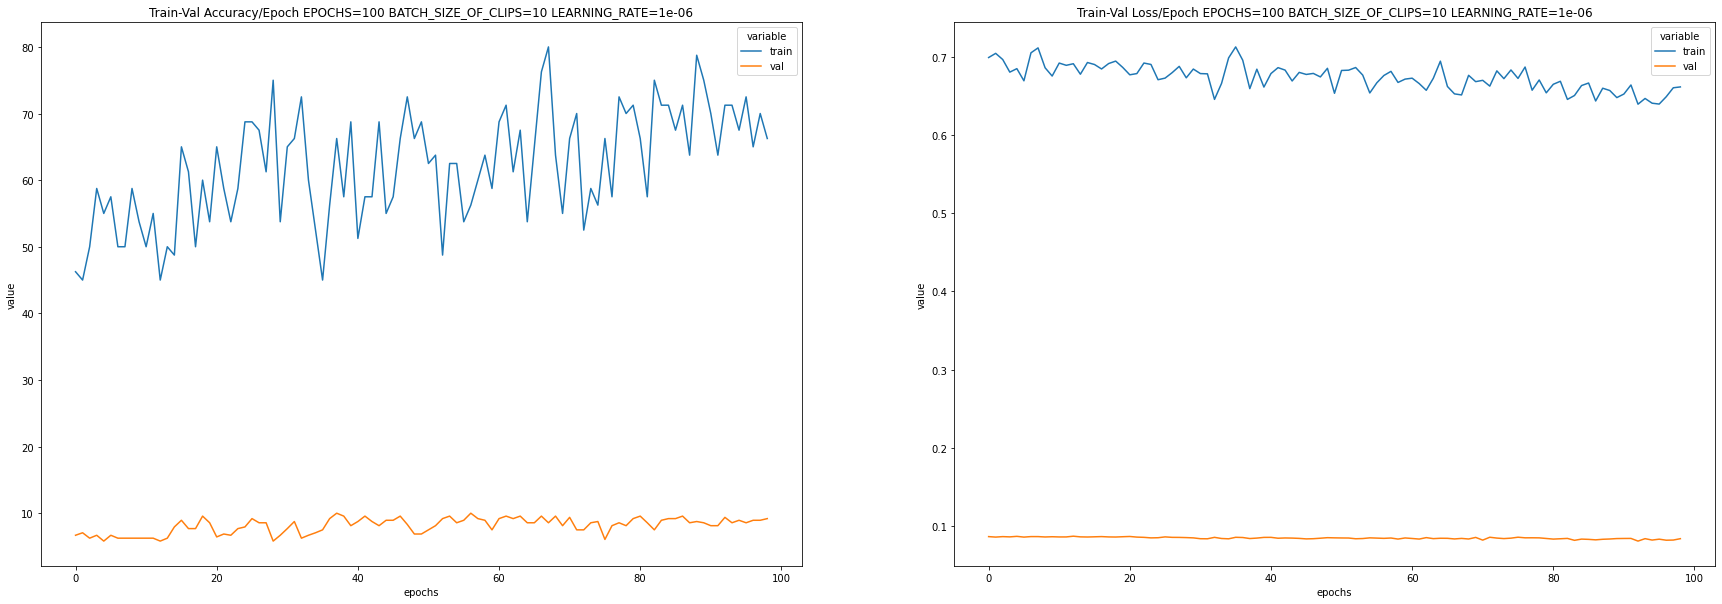

In [8]:

train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Train-Val Loss/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')

                     

In [9]:
## CODE BLURS 


## SAMPLERS
# #SubsetRandomSampler(train_idx)
# train_sampler = Data.WeightedRandomSampler(weights=[0.1, 2.0, 3.2, 3.0, 0.6], num_samples=2, replacement=True)
# print( list(train_sampler) )
# #Data.WeightedRandomSampler(weights=samp_weights_v, num_samples = n_output_classes, replacement=True)

# ##Batch size is the number of frames for one segment and those frames can be set to suffle 
# train_dataloader = DataLoader(
#     dataset=data_clip00,
#     batch_size=30,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=False,
#     sampler=train_sampler
#     )

## MODELS 
#model = TestNet()
##TODO https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#model = models.vit_l_32(pretrained=False) #has no attribute
#model = models.densenet121(pretrained=False) #has no attribute
#model = models.alexNet(pretrained=False)
#model = models.resnet50(pretrained=True)

